In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
%matplotlib inline

/home/manjake/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Подготовка данных

In [2]:
from sklearn import cross_validation
from scipy.stats import skew
from sklearn.cross_validation import KFold
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, Lasso
from math import sqrt

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

ntrain = train.shape[0]
ntest = test.shape[0]

## Preprocessing ##

y_train = np.log(train['SalePrice']+1)


train.drop(['SalePrice'], axis=1, inplace=True)

all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))


#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

all_data = pd.get_dummies(all_data)

#filling NA's with the mean of the column:
all_data = all_data.fillna(all_data.mean())

real_test = all_data[train.shape[0]:]
all_data = all_data[:train.shape[0]]
#creating matrices for sklearn:
train_data, test_data, train_labels, test_labels = cross_validation.train_test_split(np.array(all_data), np.array(y_train), 
                                                                                    test_size = 0.3,
                                                                                    random_state = 1)

### Обучение регрессии с l2 регулизацией

In [3]:
from sklearn.model_selection import cross_val_score, learning_curve
def rmse(model):
    rmse = np.sqrt(-cross_val_score(model, train_data, train_labels, scoring="neg_mean_squared_error", cv = 5))
    return rmse

In [4]:
alphas = [0.01, 0.1, 0.5, 0.9, 1, 3, 7, 15, 30, 50]
cv_ridge = [rmse(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

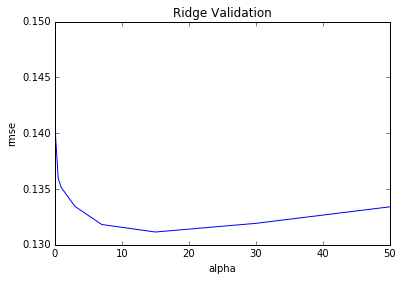

In [5]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Ridge Validation")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [6]:
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=50, test_size=0.3)
train_sizes, train_scores, test_scores = learning_curve(
        Ridge(alpha=15), train_data, train_labels, cv=cv, train_sizes=np.linspace(.1, 1.0, 20), scoring='neg_mean_squared_error')

0.10015052282 0.136987339013


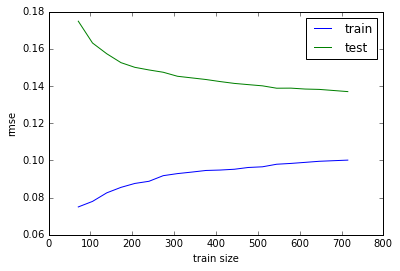

In [7]:
plt.plot(train_sizes, np.sqrt(-train_scores.mean(axis=1)), label='train')
plt.plot(train_sizes, np.sqrt(-test_scores.mean(axis=1)), label='test')
plt.legend(loc=0)
plt.xlabel('train size')
plt.ylabel('rmse')
print np.sqrt(-train_scores.mean(axis=1))[-1], np.sqrt(-test_scores.mean(axis=1))[-1]

Видим большой разрыв между трейном и тестом, это признак high variance, проведем отбор признаков для ее устранения

## Отбор признаков

In [8]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

train_reduced = SelectKBest(f_regression, k=200).fit_transform(train_data, train_labels)

/home/manjake/anaconda2/lib/python2.7/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in divide
  corr /= row_norms(X.T)
/home/manjake/anaconda2/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/manjake/anaconda2/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/manjake/anaconda2/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:1814: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [9]:
train_sizes_r, train_scores_r, test_scores_r = learning_curve(
        Ridge(alpha=15), train_reduced, train_labels, cv=cv, train_sizes=np.linspace(.1, 1.0, 20), scoring='neg_mean_squared_error')

0.105122109409 0.131055895946


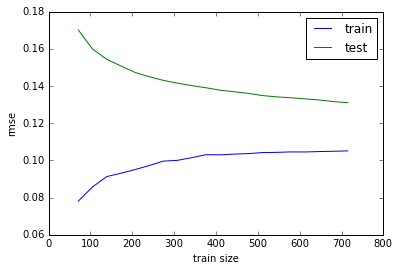

In [10]:
plt.plot(train_sizes_r, np.sqrt(-train_scores_r.mean(axis=1)), label='train')
plt.plot(train_sizes_r, np.sqrt(-test_scores_r.mean(axis=1)), label='test')
plt.legend(loc=0)
plt.xlabel('train size')
plt.ylabel('rmse')
print np.sqrt(-train_scores_r.mean(axis=1))[-1], np.sqrt(-test_scores_r.mean(axis=1))[-1]

Стало немного лучше

## Задание 2

In [11]:
xr = xgb.XGBRegressor()


In [12]:
from sklearn.grid_search import GridSearchCV

/home/manjake/anaconda2/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [13]:
xr.get_xgb_params()

{'base_score': 0.5,
 'colsample_bylevel': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'objective': 'reg:linear',
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': 0,
 'silent': 1,
 'subsample': 1}

In [14]:
parameters_grid = {
    'gamma' : [0.0],
    'learning_rate': [0.15],
    'max_depth': [3],
    'n_estimators': [1000],
    'reg_lambda': [1.0],
    'reg_alpha': [0.0, 0.1],
    'objective': ['reg:linear'],
    'min_child_weight': [7],
}

In [15]:
grid_cv = GridSearchCV(xr, parameters_grid, scoring = 'neg_mean_squared_error', cv = 5)

In [16]:
%%time
grid_cv.fit(train_data, train_labels)

CPU times: user 2min 35s, sys: 836 ms, total: 2min 35s
Wall time: 45.1 s


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [1000], 'reg_lambda': [1.0], 'reg_alpha': [0.0, 0.1], 'min_child_weight': [7], 'objective': ['reg:linear'], 'learning_rate': [0.15], 'max_depth': [3], 'gamma': [0.0]},
       pre_dispatch='2*n_jobs', refit=True,
       scoring='neg_mean_squared_error', verbose=0)

In [17]:
print np.sqrt(-grid_cv.best_score_)
print grid_cv.best_params_

0.122309011298
{'reg_alpha': 0.0, 'learning_rate': 0.15, 'min_child_weight': 7, 'n_estimators': 1000, 'reg_lambda': 1.0, 'objective': 'reg:linear', 'max_depth': 3, 'gamma': 0.0}


In [18]:
preds = grid_cv.best_estimator_.predict(np.array(real_test))

In [19]:
xgb_preds = np.expm1(preds)
solution = pd.DataFrame({"id":test.Id, "SalePrice":xgb_preds})
solution.to_csv("xgb_sol.csv", index = False)

In [20]:
ridge_best = Ridge(alpha=15).fit(train_data, train_labels)


In [21]:
ridge_preds = np.expm1(ridge_best.predict(real_test))
solution = pd.DataFrame({"id":test.Id, "SalePrice":ridge_preds})
solution.to_csv("ridge_sol.csv", index = False)